# **LeNet-5 MNIST Digits Classifier**

## **Libraries**

In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import time
import os

/home/amina/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Model Settings**

In [3]:
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

In [4]:
NUM_FEATURES = 32*32
NUM_CLASSES = 10

In [5]:
DEVICE = "cpu"
GRAYSCALE = True

## **MNIST Dataset**

In [ ]:
resize_transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

In [ ]:
train_dataset = datasets.MNIST(root='data', train=True, transform=resize_transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=resize_transform)

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])


In [11]:
device = torch.device(DEVICE)
torch.manual_seed(0)

In [12]:
for epoch in range(2):
    for batch_idx, (x, y) in enumerate(train_loader):
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        # x = x.to(device)
        # y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


## **Building the model**

In [13]:
class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Linear(120, 84),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [14]:
torch.manual_seed(RANDOM_SEED)

In [15]:
model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## **Training phase**

In [17]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [18]:
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' %(epoch+1, NUM_EPOCHS, batch_idx, len(train_loader), cost))
    model.eval()
    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0469 | Cost: 2.3058
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.4081
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.2935
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.2728
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.2707
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.1097
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.1985
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.1474
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.1713
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.1108
Epoch: 001/010 | Train: 96.682%
Time elapsed: 0.89 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.2040
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.0632
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0651
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.0811
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.2704
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.1415
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.1372
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0665
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.2061
Epoch: 002/010 | Batch 0450/0469 

In [19]:
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Total Training Time: 8.89 min


## **Evaluation**

In [20]:
with torch.set_grad_enabled(False):
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 98.48%


In [21]:
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features
    targets = targets
    break

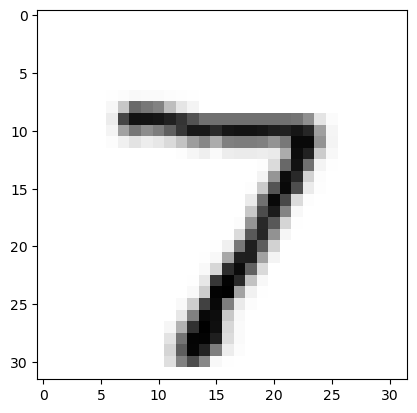

In [22]:
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [23]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%
